In [51]:
!pip install tslearn
!pip install ydata-synthetic
!pip install tsaug

In [52]:
from keras import *
import os
import numpy as np
import tensorflow as tf
import random as rn
import pandas as pd
from sklearn.model_selection import train_test_split
from tsaug.visualization import plot
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse
from tensorflow.keras.constraints import max_norm
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, TimeDistributed, AveragePooling1D, LSTM, Conv1D, Flatten, SeparableConv2D, Dropout, DepthwiseConv2D, MaxPooling2D, Activation, BatchNormalization, MaxPooling1D, Softmax, Input, Conv2D, AveragePooling2D
from numpy import genfromtxt
import scipy.io
import pandas as pd
import importlib
import sys  
from sklearn.preprocessing import MinMaxScaler
import sklearn.cluster as cluster
import matplotlib.pyplot as plt
from tslearn.generators import random_walks
from tslearn.clustering import TimeSeriesKMeans
from ydata_synthetic.synthesizers.timeseries import TimeGAN

os.environ['PYTHONHASHSEED']='0'
np.random.seed(1)
rn.seed(2)

#### READ DATA

In [53]:
mat = scipy.io.loadmat('subj1_train1.mat')
trials = np.swapaxes(mat['data'],0,2)
trials = np.swapaxes(trials,1,2)

mat1 = scipy.io.loadmat('subj1_train2.mat')

trials1 = np.swapaxes(mat1['data'],0,2)
trials1 = np.swapaxes(trials1,1,2)

mat2 = scipy.io.loadmat('subj2_train1.mat')

trials2 = np.swapaxes(mat2['data'],0,2)
trials2 = np.swapaxes(trials2,1,2)

mat3 = scipy.io.loadmat('subj2_train2.mat')

trials3 = np.swapaxes(mat3['data'],0,2)
trials3 = np.swapaxes(trials3,1,2)

trials = np.concatenate([trials, trials1, trials2, trials3])

labels_map = {0: '9Hz', 1: '10Hz', 
                2: '12Hz', 3: '15Hz'}

alt_labels_map = {0: 'TOP', 1: 'RIGHT', 
                2: 'BOTTOM', 3: 'LEFT'}

def read_labels (file_path, labels_map):
    oneHot_labels=genfromtxt(file_path,delimiter=' ')
    labels = np.argmax(oneHot_labels, axis=1)

    return labels, [labels_map[idx] for idx in labels]

labels = read_labels('classInfo_4_5.m', labels_map)

lab = labels[0].tolist()
for x in labels[0]:
  lab.append(x)
  lab.append(x)
  lab.append(x)

(<Figure size 1152x1152 with 8 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       dtype=object))

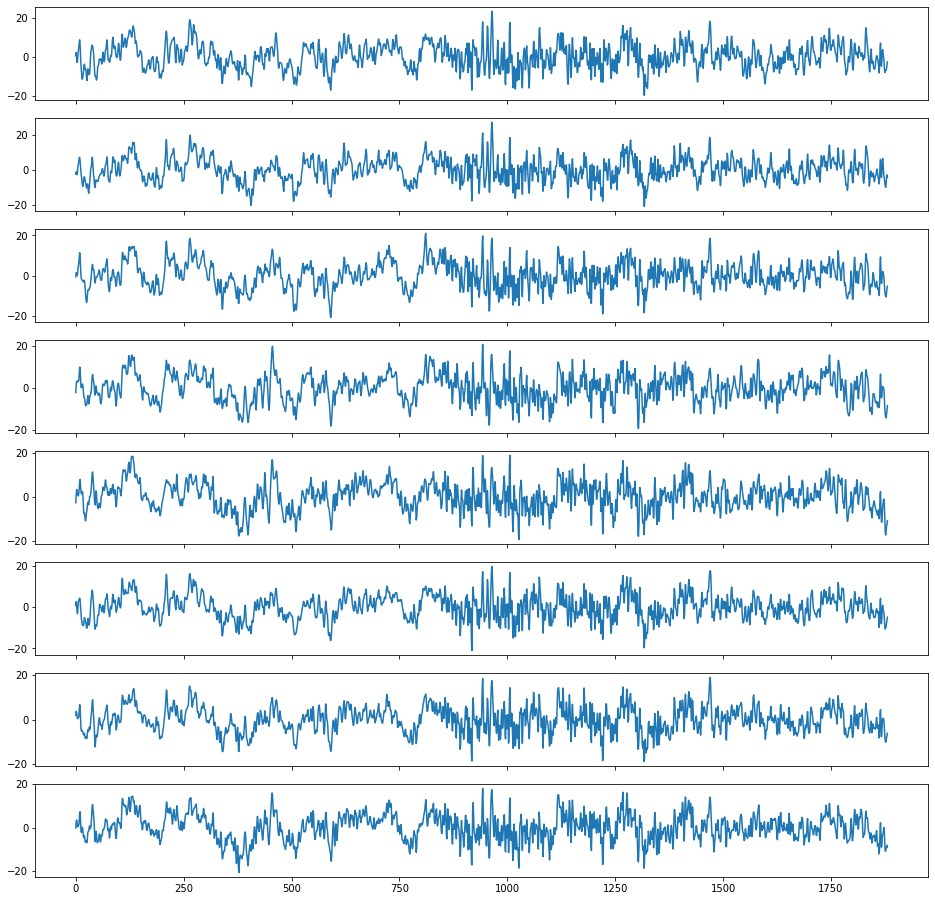

In [54]:
plot(trials[0])

#### TIMESERIES AUGMENTATION
Compute 10 new trials from every trial.

TODO:


*   Test other timeseries augmenter 




In [55]:
my_augmenter = (
TimeWarp() * 15  # random time warping 15 times in parallel
+ Crop(size=1882)  # random crop subsequences with length 300
+ Quantize(n_levels=[10, 20, 30])  # random quantize to 10-, 20-, or 30- level sets
+ Drift(max_drift=(0.1, 0.5)) @ 0.8  # with 80% probability, random drift the signal up to 10% - 50%
+ Reverse() @ 0.5  # with 50% probability, reverse the sequence
)
trials_synt = []
labels_synt = []
for x in range(len(trials)):
  i = my_augmenter.augment(trials[x])
  ls1 = []
  for t in range(i.shape[0]):
    ls1.append(i[t])
    if len(ls1) == 8:
      trials_synt.append(ls1)
      ls1 = []
      labels_synt.append(lab[x])

trials_synt = np.array(trials_synt)
trials_synt.shape

(1200, 8, 1882)

(<Figure size 1152x1152 with 8 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       dtype=object))

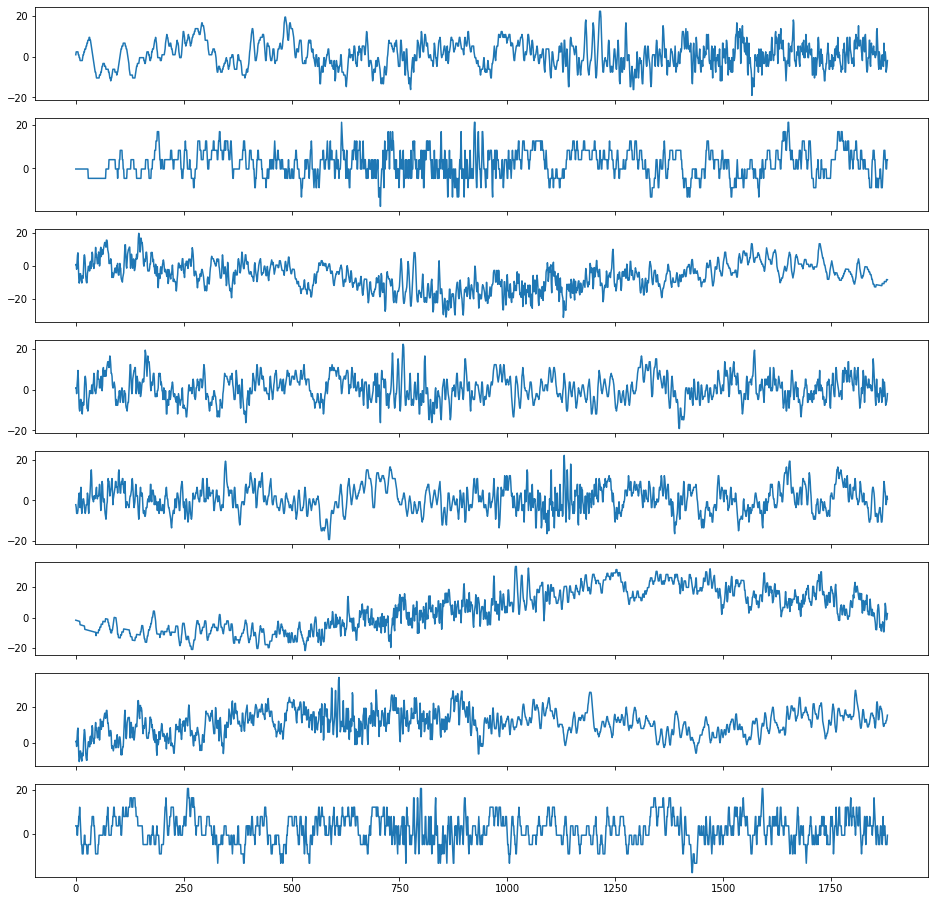

In [56]:
plot(trials_synt[0])

#### RESHAPE AND CREATE TRAIN/TEST DATA FOR CNN

In [57]:
x_trials_synt = np.resize(trials_synt, (1200, 8, 1882))
y_train = to_categorical(labels_synt)


trials1 = np.resize(trials, (80, 8, 1882))
x_train_ft, x_test_ft, y_train_ft, y_test_ft = train_test_split(trials1, lab, test_size= 0.2, random_state=42)
y_test_ft = to_categorical(y_test_ft)
y_train_ft = to_categorical(y_train_ft)

#### DEFINE, TRAIN, FINE-TUNE, TEST OF CNN
TODO:


*   Hyperparameters search
*   Different architectures



In [58]:
# DEFINE HYPERPARAMETERS FOR CLASSIFICATION
nb_classes = 4
Chans = 8
Samples = 1882 
dropoutRate = 0.5
kernLength = 10
F1 = 256 
D = 1
F2 = 256
dropoutType = Dropout

#DEFINE MODEL

input1   = Input(shape = (8, 1882, 1))
block1  = Conv2D(F1, (1, kernLength), padding = 'same',
                  input_shape = (Chans, Samples, 1))(input1)
block1 = BatchNormalization()(block1)
block1 = DepthwiseConv2D((Chans, 1), use_bias = False, 
                          depth_multiplier = D,
                          depthwise_constraint = max_norm(1.))(block1)
block1 = BatchNormalization()(block1)
block1= Activation('elu')(block1)
block1= AveragePooling2D((1, 4))(block1)
block1= dropoutType(dropoutRate)(block1)
    
block2= SeparableConv2D(F2, (1, 16), padding = 'same')(block1)
block2= BatchNormalization()(block2)
block2= Activation('elu')(block2)
block2= AveragePooling2D((1, 8))(block2)
block2= dropoutType(dropoutRate)(block2)
        
flatten= Flatten(name = 'flatten')(block2)
dense1 = Dense(600, name = 'dense1')(flatten)

dense= Dense(nb_classes, name = 'dense')(dense1)
softmax= Activation('softmax', name = 'softmax')(dense)
    
model = Model(inputs=input1, outputs=softmax)

#COMPILE MODEL
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

#TRAIN ON SYNTHETIC DATA
model.fit(trials_synt, y_train, epochs = 40, batch_size=16)
model.evaluate(x_test_ft, y_test_ft)

#FINE-TUNE ON TRIAL DATA
model.fit(x_train_ft, y_train_ft, epochs = 10, batch_size=1)
model.evaluate(x_test_ft, y_test_ft)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 8, 1882, 1)]      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 8, 1882, 256)      2816      
_________________________________________________________________
batch_normalization_9 (Batch (None, 8, 1882, 256)      1024      
_________________________________________________________________
depthwise_conv2d_3 (Depthwis (None, 1, 1882, 256)      2048      
_________________________________________________________________
batch_normalization_10 (Batc (None, 1, 1882, 256)      1024      
_________________________________________________________________
activation_6 (Activation)    (None, 1, 1882, 256)      0         
_________________________________________________________________
average_pooling2d_14 (Averag (None, 1, 470, 256)       0   

[12.28661060333252, 0.25]

#### SCALE DATA TO [-1, 1]

TODO:


*   Different scalers



In [59]:
x_train = np.resize(x_trials_synt, [800, 1882, 8])
ls = []
for x in range(len(x_train1)):
  scaler = MinMaxScaler()
  train_data = scaler.fit_transform(x_train1[x])
  ls.append(train_data)

x_train_gan = np.array(ls)

#### DEFINE HYPERPARAMETERS FOR TIMEGAN
TODO:

*   Hyperparameters search



In [60]:
model = TimeGAN

seq_len = 1882
n_seq = 8
hidden_dim = 6
noise_dim = 8
dim = 32
batch_size = 256
log_step = 100
learning_rate = 5e-4

gan_args = [batch_size, learning_rate, noise_dim, 1882, 2, (0, 1), dim]
models_dir = './cache'
synthesizer = model(gan_args, hidden_dim=32, seq_len=seq_len, n_seq=n_seq, gamma=0.1)

#### TRAIN TIMEGAN

In [61]:
synthesizer.train(x_train_gan, train_steps=10)



Emddeding network training:   0%|          | 0/10 [00:00<?, ?it/s]

Emddeding network training:  10%|█         | 1/10 [00:05<00:47,  5.28s/it]

Emddeding network training:  20%|██        | 2/10 [00:05<00:30,  3.86s/it]

Emddeding network training:  30%|███       | 3/10 [00:06<00:20,  2.87s/it]

Emddeding network training:  40%|████      | 4/10 [00:06<00:12,  2.17s/it]

Emddeding network training:  50%|█████     | 5/10 [00:07<00:08,  1.68s/it]

Emddeding network training:  60%|██████    | 6/10 [00:08<00:05,  1.34s/it]

Emddeding network training:  70%|███████   | 7/10 [00:08<00:03,  1.10s/it]

Emddeding network training:  80%|████████  | 8/10 [00:09<00:01,  1.07it/s]

Emddeding network training:  90%|█████████ | 9/10 [00:09<00:00,  1.23it/s]

Emddeding network training: 100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


Supervised network training:   0%|          | 0/10 [00:00<?, ?it/s]

Supervised network training:  10%|█         | 1/10 [00:04<00:36,  4.10s/it]

Supervised network tra

#### SYNTHETIZE NEW DATA FROM TIMEGAN

In [62]:
data_sample = synthesizer.sample(10000)
data_sample[0]



Synthetic data generation:   0%|          | 0/40 [00:00<?, ?it/s]

Synthetic data generation:   2%|▎         | 1/40 [00:00<00:15,  2.51it/s]

Synthetic data generation:   5%|▌         | 2/40 [00:00<00:14,  2.55it/s]

Synthetic data generation:   8%|▊         | 3/40 [00:01<00:14,  2.53it/s]

Synthetic data generation:  10%|█         | 4/40 [00:01<00:13,  2.59it/s]

Synthetic data generation:  12%|█▎        | 5/40 [00:01<00:13,  2.60it/s]

Synthetic data generation:  15%|█▌        | 6/40 [00:02<00:12,  2.62it/s]

Synthetic data generation:  18%|█▊        | 7/40 [00:02<00:12,  2.62it/s]

Synthetic data generation:  20%|██        | 8/40 [00:03<00:12,  2.62it/s]

Synthetic data generation:  22%|██▎       | 9/40 [00:03<00:11,  2.64it/s]

Synthetic data generation:  25%|██▌       | 10/40 [00:03<00:11,  2.60it/s]

Synthetic data generation:  28%|██▊       | 11/40 [00:04<00:11,  2.60it/s]

Synthetic data generation:  30%|███       | 12/40 [00:04<00:10,  2.58it/s]

Synthetic data generation:  

array([[0.5008948 , 0.5038953 , 0.4985406 , ..., 0.5010847 , 0.4950519 ,
        0.497689  ],
       [0.5009038 , 0.5059569 , 0.49828452, ..., 0.49992108, 0.490715  ,
        0.4958513 ],
       [0.5004553 , 0.5068525 , 0.4986778 , ..., 0.49817574, 0.4884891 ,
        0.49533764],
       ...,
       [0.5021073 , 0.50313336, 0.50437313, ..., 0.5030143 , 0.5015813 ,
        0.5081914 ],
       [0.5021185 , 0.5031209 , 0.50438315, ..., 0.50301534, 0.5015886 ,
        0.50819576],
       [0.5021363 , 0.50310946, 0.50439817, ..., 0.5030201 , 0.5015969 ,
        0.50820065]], dtype=float32)

In [81]:
data_sample1 = []
for x in data_sample:
  data_sample1.append(scaler.inverse_transform(x))
data_sample1[0]

array([[0.5008948 , 0.5038953 , 0.4985406 , ..., 0.5010847 , 0.4950519 ,
        0.497689  ],
       [0.5009038 , 0.5059569 , 0.49828452, ..., 0.49992108, 0.490715  ,
        0.4958513 ],
       [0.5004553 , 0.5068525 , 0.4986778 , ..., 0.49817574, 0.4884891 ,
        0.49533764],
       ...,
       [0.5021073 , 0.50313336, 0.50437313, ..., 0.5030143 , 0.5015813 ,
        0.5081914 ],
       [0.5021185 , 0.5031209 , 0.50438315, ..., 0.50301534, 0.5015886 ,
        0.50819576],
       [0.5021363 , 0.50310946, 0.50439817, ..., 0.5030201 , 0.5015969 ,
        0.50820065]], dtype=float32)

In [82]:
data_sample1[0].shape

(1882, 8)

#### CREATE LABELS FOR SYNTHETIC DATA

In [71]:
km = TimeSeriesKMeans(n_clusters=4, metric="dtw", max_iter=100,
                       random_state=0).fit(trials)
pred = km.predict(data_sample1)
pred

array([3, 3, 3, ..., 3, 3, 3])

(<Figure size 1152x144 with 1 Axes>, <AxesSubplot:>)

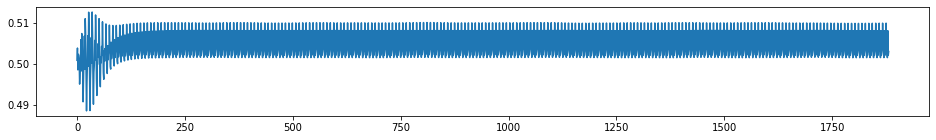

In [89]:
test = np.resize(data_sample1[0], (8, 1882))
plot(test[0])

#### PREPARE DATA FOR CNN

In [ ]:
trials_synt = np.resize(data_sample1, (10004, 8, 1882))
y_train_synt = to_categorical(pred)

trials1 = np.resize(trials, (80, 8, 1882))
x_train_ft, x_test_ft, y_train_ft, y_test_ft = train_test_split(trials1, lab, test_size= 0.2, random_state=42)
y_test_ft = to_categorical(y_test_ft)
y_train_ft = to_categorical(y_train_ft)

####DEFINE, TRAIN, FINE-TUNE, TEST CNN

TODO:


*   Search for hyperparameters



In [90]:
nb_classes = 4
Chans = 8
Samples = 1882 
dropoutRate = 0.5
kernLength = 10
F1 = 256 
D = 1
F2 = 256
dropoutType = Dropout

input1   = Input(shape = (8, 1882, 1))

##################################################################
block1 = Conv2D(F1, (1, kernLength), input_shape = (Chans, Samples, 1))(input1)
block1 = BatchNormalization()(block1)
block1 = DepthwiseConv2D((Chans, 1), use_bias = False, 
                          depth_multiplier = D,
                          depthwise_constraint = max_norm(1.))(block1)
block1 = BatchNormalization()(block1)
block1= Activation('elu')(block1)
block1= AveragePooling2D((1, 4))(block1)
block1= dropoutType(dropoutRate)(block1)
    
block2= SeparableConv2D(F2, (1, 16), padding = 'same')(block1)
block2= BatchNormalization()(block2)
block2= Activation('elu')(block2)
block2= AveragePooling2D((1, 8))(block2)
block2= dropoutType(dropoutRate)(block2)
        
flatten= Flatten(name = 'flatten')(block2)
dense1 = Dense(1000, name = 'dense1')(flatten)

dense= Dense(nb_classes, name = 'dense')(dense1)
softmax= Activation('softmax', name = 'softmax')(dense)
    
model = Model(inputs=input1, outputs=softmax)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()
model.fit(trials_synt, y_train, epochs = 1, batch_size=128)
model.evaluate(x_test_ft, y_test_ft)
model.fit(x_train_ft, y_train_ft, epochs = 10, batch_size=1)
model.evaluate(x_test_ft, y_test_ft)

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 8, 1882, 1)]      0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 8, 1873, 256)      2816      
_________________________________________________________________
batch_normalization_12 (Batc (None, 8, 1873, 256)      1024      
_________________________________________________________________
depthwise_conv2d_4 (Depthwis (None, 1, 1873, 256)      2048      
_________________________________________________________________
batch_normalization_13 (Batc (None, 1, 1873, 256)      1024      
_________________________________________________________________
activation_8 (Activation)    (None, 1, 1873, 256)      0         
_________________________________________________________________
average_pooling2d_16 (Averag (None, 1, 468, 256)       0   

KeyboardInterrupt: ignored